# 5. BERT 嵌入 + Transformer  (雙 GPU / T2 x 2 / To16.2 TFLOPS) 

# 對比四種方法
| **方法**                  | **特徵工程**                | **模型**                    | **準確率預估** | **優勢**                                     | **劣勢**                                      | **GPU 支援**            |
|--------------------------|----------------------------|-----------------------------|----------------|---------------------------------------------|----------------------------------------------|-------------------------|
| **TF-IDF + 隨機森林**      | 稀疏特徵表示，詞頻與逆文檔頻率權重 | 隨機森林                    | 75%-82%       | 模型穩定性強，對噪聲和高維數據不敏感          | 無法處理非線性模式，對語義信息利用不足           | 不支持                  |
| **TF-IDF + Boosting**      | 稀疏特徵表示，詞頻與逆文檔頻率權重 | XGBoost 或 LightGBM         | 78%-85%       | 擅長處理稀疏特徵，對錯分樣本有良好適應能力      | 訓練成本略高，需調參以達到最佳效果              | 支持（顯著加速，適合大數據集）|
| **Word2Vec + 隨機森林**     | 詞嵌入，計算句向量平均值       | 隨機森林                    | 72%-80%       | 能結合詞嵌入語義特徵，提升語義捕捉能力          | 詞嵌入需預處理，隨機森林對非線性語義的處理有限     | 不支持                  |
| **Word2Vec + CNN**         | 詞嵌入，保留語序            | 卷積神經網絡                | 75%-85%       | 捕捉局部語義特徵，對短文本效果佳               | 訓練需較多資源，對長文本效果有限               | 支持（顯著加速）         |
| **BERT 嵌入 + Transformer**| 上下文語義嵌入，保留全局語義 | 預訓練 BERT 模型             | 85%-90%       | 能捕捉上下文語義，分類準確率最高               | 訓練和推理成本高，需要大量數據和資源支持         | 支持（必要，否則速度較慢） |

In [1]:
#kaggle 前置作業
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json
/kaggle/input/dm-2024-isa-5810-lab-2-homework/sampleSubmission.csv
/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv
/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv


In [2]:
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

# 這部分請小心執行，這是 "未做過"  雜訊處理的程式碼

In [ ]:


# 資料處理部分
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# 這部分請小心執行，這是 "做過" 雜訊處理的程式碼

In [3]:
import json
import re
import emoji
import pandas as pd

# 定義表情符號到關鍵字的映射字典
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

# 定義清理推文文本的函數
def clean_tweet(text, emoji_dict):
    # 將定義的表情符號替換為對應的關鍵詞
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    # 移除其餘的表情符號
    text = emoji.replace_emoji(text, replace='')
    # 移除 <LH> 標籤
    text = re.sub(r'<LH>', '', text)
    # 移除多餘的空白字元
    text = text.strip()
    return text

# 讀取推文資料
data1 = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data1.append(json.loads(line))

# 處理每條推文並儲存結果
processed_tweets = []
for entry in data1:
    # 檢查 '_source' 和 'tweet' 是否存在於記錄中
    if '_source' in entry and 'tweet' in entry['_source']:
        tweet = entry['_source']['tweet']
        # 檢查 'text' 是否存在於 'tweet' 中
        if 'text' in tweet:
            tweet_text = tweet['text']
            cleaned_text = clean_tweet(tweet_text, emoji_dict)
            # 創建處理後的推文記錄，保留 '_source' 和 'tweet'
            processed_tweet = {
                '_source': {
                    'tweet': tweet.copy()
                }
            }
            # 更新清理後的文本
            processed_tweet['_source']['tweet']['text'] = cleaned_text
            processed_tweets.append(processed_tweet)
        else:
            print("記錄中缺少 'text' 鍵")
    else:
        print("記錄中缺少 '_source' 或 'tweet' 鍵")

# 將處理後的推文資料存儲為 JSON 檔案
with open('/kaggle/working/tweets_DM_filtered_1.json', 'w') as outfile:
    json.dump(processed_tweets, outfile, ensure_ascii=False, indent=4)



# 將處理後的資料轉換為 DataFrame
df_processed = pd.DataFrame(processed_tweets)

# 定義輸出目錄和檔案名稱
output_dir = '/kaggle/working/'
output_file = 'tweets_DM_filtered_1.json'

# 檢查並創建目錄（如果不存在）
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 將處理後的 DataFrame 儲存為 JSON 檔案
output_path = os.path.join(output_dir, output_file)
df_processed.to_json(output_path, orient='records', lines=True, force_ascii=False)

# 把 /kaggle/working/tweets_DM_filtered_1.json 載入成為 data , 可樣就可以跟原本程式合併

data = []
with open('/kaggle/working/tweets_DM_filtered_1.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
f.close()
print("ok")

ok


# 以下就都一樣了

In [4]:


emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

# 抽樣與標籤編碼
train_data_sample = train_data.sample(frac=0.3, random_state=42)
y_train_data = train_data_sample['emotion']
X_train_data = train_data_sample['text']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# 定義 PyTorch Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 初始化 BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

# 增大批次大小並優化數據加載
train_loader = DataLoader(
    TweetDataset(X_train, y_train, tokenizer, max_len),
    batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    TweetDataset(X_val, y_val, tokenizer, max_len),
    batch_size=64, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    TweetDataset(test_data['text'], [0] * len(test_data), tokenizer, max_len),
    batch_size=64, num_workers=4, pin_memory=True
)

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(le.classes_)
)

# 使用 DataParallel 將模型分佈到多個 GPU
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# 使用 PyTorch 的 AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = torch.nn.CrossEntropyLoss()

# 初始化 GradScaler
scaler = GradScaler()

# 訓練函數
def train_epoch(model, data_loader, criterion, optimizer, scaler, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():  # 移除不支援的參數
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 驗證函數
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():  # 移除不支援的參數
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 訓練與驗證
epochs = 3
for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    print(f'Validation loss: {val_loss}, accuracy: {val_acc}')

# 測試資料預測
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        with autocast():  # 移除不支援的參數
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            test_predictions.extend(preds.cpu().numpy())

# 輸出結果
test_data['emotion'] = le.inverse_transform(test_predictions)
submission = test_data[['tweet_id', 'emotion']]
# submission.to_csv('/kaggle/working/submission.csv', index=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs for training


/tmp/ipykernel_30/1215593766.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_30/1215593766.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 移除不支援的參數
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_30/1215593766.py:137: FutureWarning: `torch.cuda.amp.autocast(args...

Epoch 1/3
Train loss: 1.1770673895306136, accuracy: 0.5763322652634139
Validation loss: 1.073242626675853, accuracy: 0.6119299301849
Epoch 2/3
Train loss: 0.98582218688138, accuracy: 0.6455397226491607
Validation loss: 1.0463521530451598, accuracy: 0.6282780099802017
Epoch 3/3
Train loss: 0.841758851073013, accuracy: 0.6970154826720851
Validation loss: 1.0769762372529066, accuracy: 0.6294705398802839


/tmp/ipykernel_30/1215593766.py:166: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 移除不支援的參數
/tmp/ipykernel_30/1215593766.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['emotion'] = le.inverse_transform(test_predictions)


In [8]:

print(f"\nValidation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.6294


In [10]:
submission.head()

,tweet_id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,joy
33,0x26289a,trust


# 分析部分 : 混淆矩陣 , Classification Report

## 準確率紀錄 :
### 資料沒清洗過
- Validation Accuracy: 0.6439

### 資料清洗過
- Validation Accuracy: 0.6294
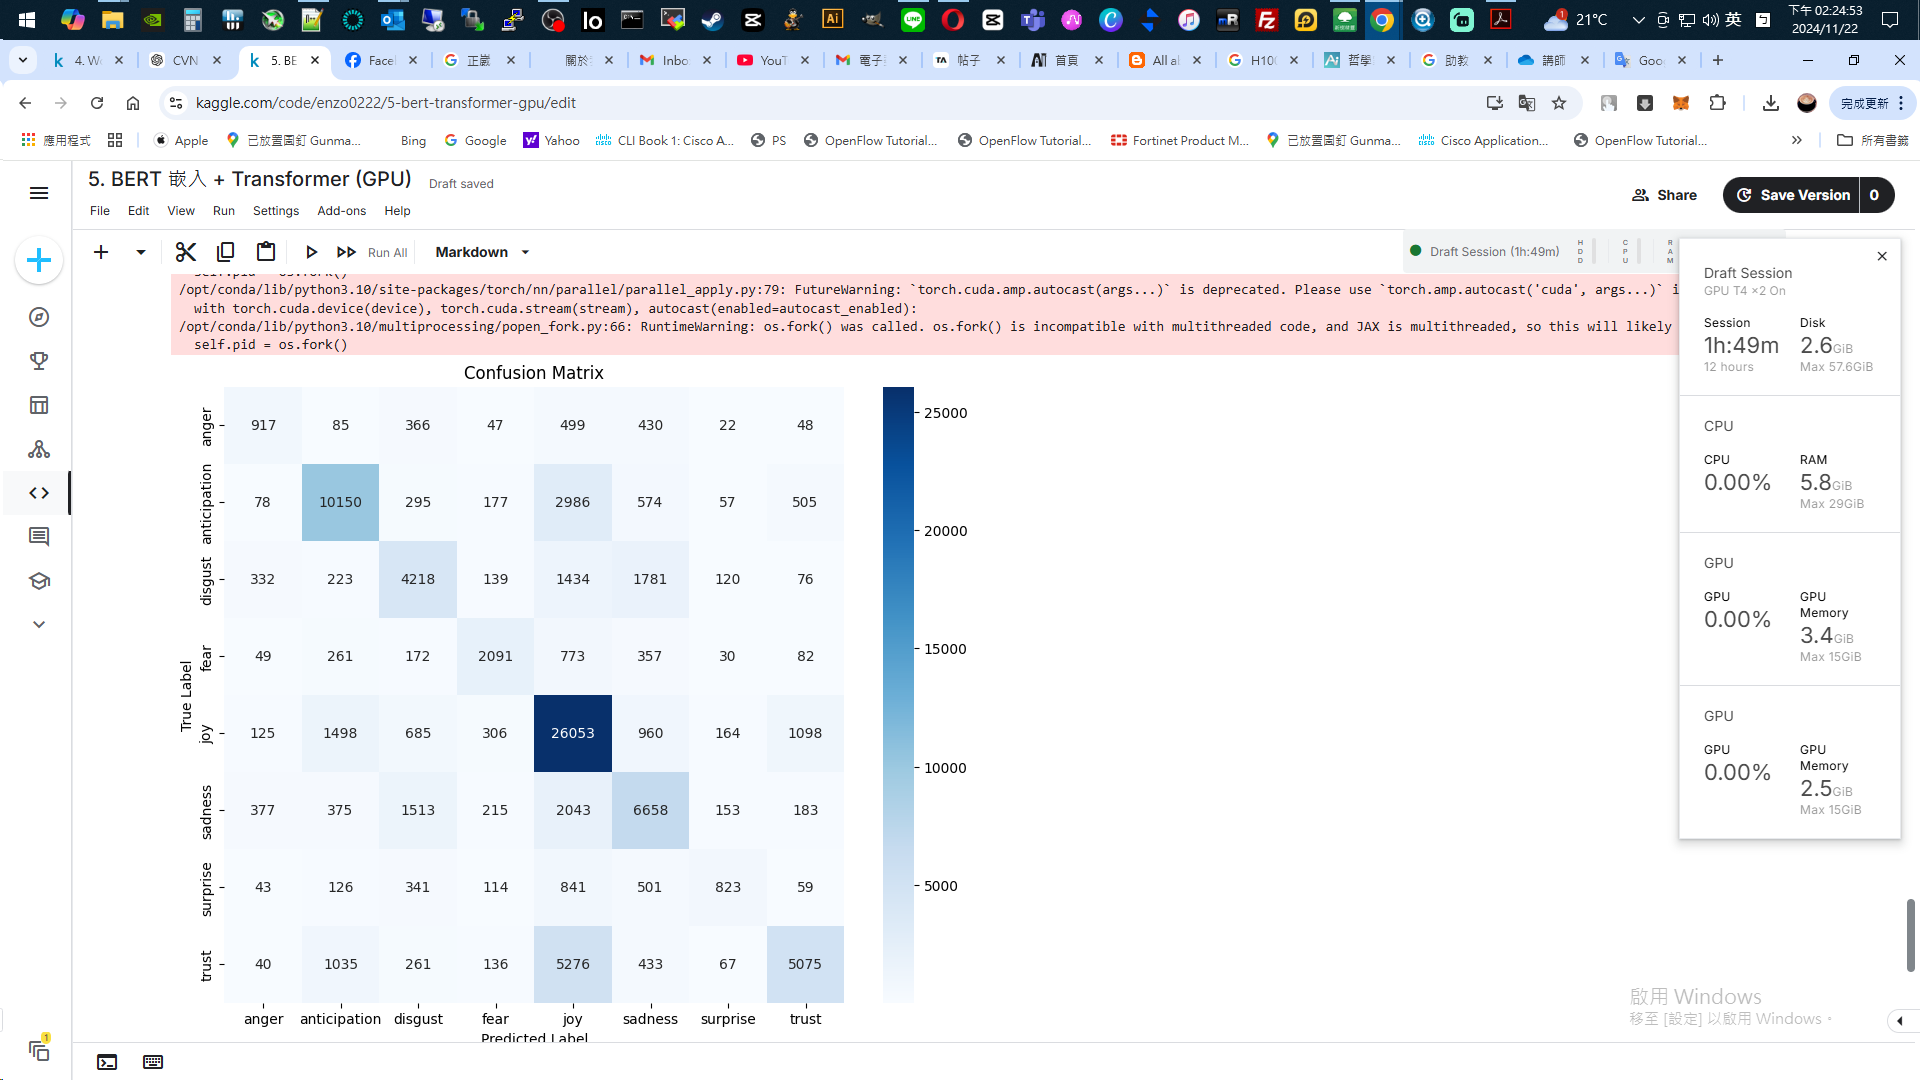

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


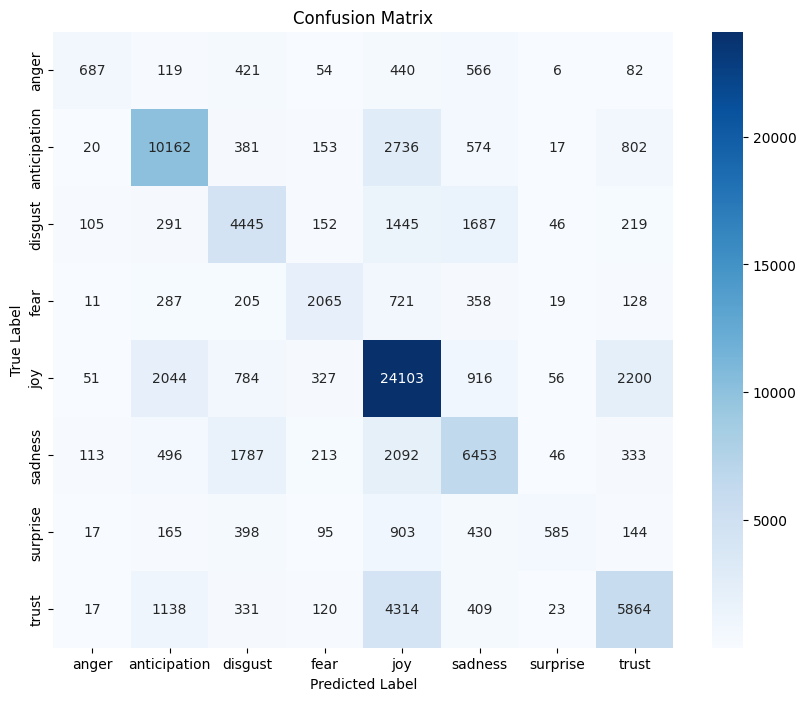

Confusion Matrix:
[[  687   119   421    54   440   566     6    82]
 [   20 10162   381   153  2736   574    17   802]
 [  105   291  4445   152  1445  1687    46   219]
 [   11   287   205  2065   721   358    19   128]
 [   51  2044   784   327 24103   916    56  2200]
 [  113   496  1787   213  2092  6453    46   333]
 [   17   165   398    95   903   430   585   144]
 [   17  1138   331   120  4314   409    23  5864]]

Classification Report:
              precision    recall  f1-score   support

       anger       0.67      0.29      0.40      2375
anticipation       0.69      0.68      0.69     14845
     disgust       0.51      0.53      0.52      8390
        fear       0.65      0.54      0.59      3794
         joy       0.66      0.79      0.72     30481
     sadness       0.57      0.56      0.56     11533
    surprise       0.73      0.21      0.33      2737
       trust       0.60      0.48      0.53     12216

    accuracy                           0.63     86371
   macr

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 預測驗證集資料
model.eval()
val_predictions = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        val_predictions.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# 計算混淆矩陣
cm = confusion_matrix(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)

# 1. 畫出混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 2. 列出混淆矩陣
print("Confusion Matrix:")
print(cm)

# 3. 做出分類報告
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions, target_names=le.classes_))

# 4. 印出 Accuracy
print(f"\nValidation Accuracy: {accuracy:.4f}")


In [1]:
!pip install emoji
!pip install regex

In [5]:
import json
import pandas as pd
import emoji
import regex

# 定義從文本中提取表情符號的函數
def extract_emojis(text):
    """從給定的文本中提取所有表情符號。"""
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)
    return emoji_list

# 讀取 JSON 檔案並解析為列表
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# 提取所有推文中的表情符號
all_emojis = []
for entry in data:
    tweet_text = entry['_source']['tweet']['text']
    emojis_in_tweet = extract_emojis(tweet_text)
    all_emojis.extend(emojis_in_tweet)

# 移除重複的表情符號
unique_emojis = list(set(all_emojis))

# 建立包含表情符號資訊的列表
emoji_data = []
for emj in unique_emojis:
    unicode_repr = emj.encode('unicode-escape').decode('ASCII')
    description = emoji.demojize(emj).strip(':').replace('_', ' ')
    emoji_data.append({'emoji': emj, 'unicode': unicode_repr, 'description': description})

# 將列表轉換為 DataFrame
df_emojis = pd.DataFrame(emoji_data)

# 顯示 DataFrame 的前幾行
print(df_emojis.head())


   emoji                                 unicode  \
0     ⏱️                            \u23f1\ufe0f   
1      🍁                              \U0001f341   
2  🏋🏽‍♂️  \U0001f3cb\U0001f3fd\u200d\u2642\ufe0f   
3      💦                              \U0001f4a6   
4      🎩                              \U0001f3a9   

                            description  
0                             stopwatch  
1                            maple leaf  
2  man lifting weights medium skin tone  
3                        sweat droplets  
4                               top hat  


In [6]:
df_emojis.shape

(2352, 3)

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128175 (\N{HUNDRED POINTS SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylab

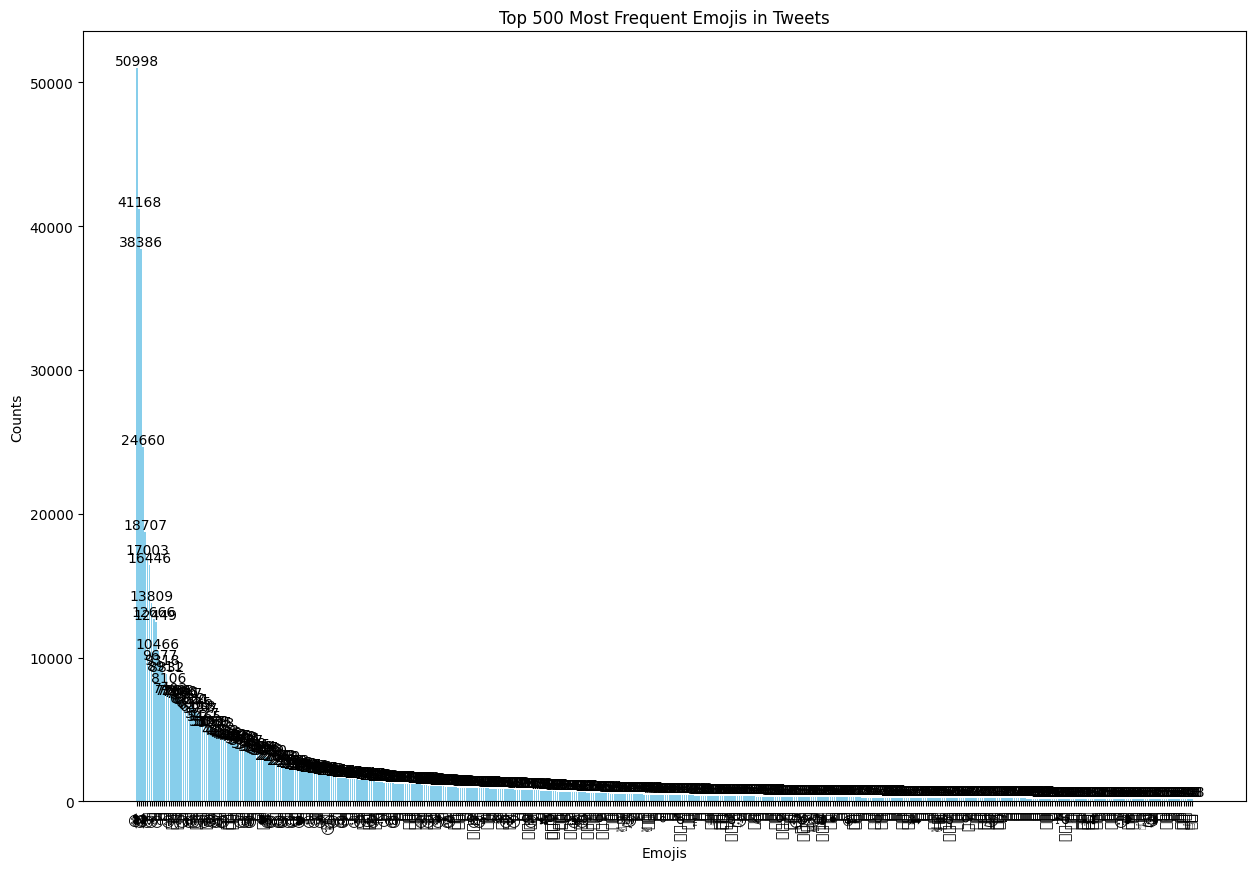

In [2]:
import emoji
import json
import regex
import collections
import matplotlib.pyplot as plt

# 定義從文本中提取表情符號的函數
def extract_emojis(text):
    """從給定的文本中提取所有表情符號。"""
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)
    return emoji_list

# 讀取 JSON 檔案並解析為列表
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# 提取所有推文中的表情符號
all_emojis = []
for entry in data:
    tweet_text = entry['_source']['tweet']['text']
    emojis_in_tweet = extract_emojis(tweet_text)
    all_emojis.extend(emojis_in_tweet)

# 計算每個表情符號的出現次數
emoji_counter = collections.Counter(all_emojis)

# 取得出現頻率最高的前 100 個表情符號
top_500_emojis = emoji_counter.most_common(500)

# 分離表情符號和對應的計數
emojis, counts = zip(*top_500_emojis)

# 設定圖表大小
plt.figure(figsize=(15, 10))

# 繪製直方圖
bars = plt.bar(emojis, counts, color='skyblue')

# 在每個柱狀上標註對應的數量
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, count, ha='center', va='bottom')

# 設定圖表標題和軸標籤
plt.title('Top 500 Most Frequent Emojis in Tweets')
plt.xlabel('Emojis')
plt.ylabel('Counts')

# 調整 x 軸標籤的顯示角度
plt.xticks(rotation=90)

# 顯示圖表
plt.show()


In [7]:
top_500_emojis

[('😂', 50998),
 ('❤️', 41168),
 ('😍', 38386),
 ('😭', 24660),
 ('❤', 18707),
 ('😊', 17003),
 ('🙏', 16446),
 ('😘', 13809),
 ('💕', 12666),
 ('🔥', 12449),
 ('😩', 10466),
 ('🤔', 9677),
 ('💯', 9318),
 ('💙', 8911),
 ('🙄', 8832),
 ('😁', 8106),
 ('🙌', 7403),
 ('🙏🏾', 7284),
 ('👍', 7284),
 ('🙏🏽', 7262),
 ('✨', 7186),
 ('💜', 7086),
 ('😇', 7051),
 ('👏', 7017),
 ('🤗', 6712),
 ('😎', 6620),
 ('💖', 6611),
 ('😡', 6445),
 ('🙏🏼', 6269),
 ('😢', 6118),
 ('🤣', 5997),
 ('🎉', 5627),
 ('😀', 5465),
 ('🙏🏻', 5126),
 ('👌', 5117),
 ('☺️', 5095),
 ('😱', 5069),
 ('🎶', 5035),
 ('😉', 4948),
 ('💞', 4493),
 ('😳', 4482),
 ('😒', 4326),
 ('💗', 4282),
 ('🙌🏽', 4170),
 ('🙌🏾', 4162),
 ('🙌🏼', 4117),
 ('🙃', 4115),
 ('💛', 4058),
 ('💚', 4040),
 ('😔', 4008),
 ('🙈', 3946),
 ('😌', 3871),
 ('💪', 3777),
 ('😅', 3576),
 ('😃', 3494),
 ('😬', 3485),
 ('🌈', 3360),
 ('💔', 3349),
 ('👀', 3334),
 ('💋', 3297),
 ('🙌🏻', 3196),
 ('♥️', 3126),
 ('😄', 3059),
 ('😜', 3050),
 ('😫', 2752),
 ('💓', 2722),
 ('😤', 2709),
 ('😆', 2703),
 ('😏', 2662),
 ('😋', 2659)

In [ ]:
import emoji
import json
import regex
import collections
import matplotlib.pyplot as plt

# 定義從文本中提取表情符號的函數
def extract_emojis(text):
    """從給定的文本中提取所有表情符號。"""
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)
    return emoji_list

# 讀取 JSON 檔案並解析為列表
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# 提取所有推文中的表情符號
all_emojis = []
for entry in data:
    tweet_text = entry['_source']['tweet']['text']
    emojis_in_tweet = extract_emojis(tweet_text)
    all_emojis.extend(emojis_in_tweet)

# 計算每個表情符號的出現次數
emoji_counter = collections.Counter(all_emojis)

# 取得出現頻率最高的前 50 個表情符號
top_50_emojis = emoji_counter.most_common(50)

# 分離表情符號和對應的計數
emojis, counts = zip(*top_50_emojis)

# 設定圖表大小
plt.figure(figsize=(15, 10))

# 繪製直方圖
bars = plt.bar(emojis, counts, color='skyblue')

# 在每個柱狀上標註對應的數量
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, count, ha='center', va='bottom')

# 設定圖表標題和軸標籤
plt.title('Top 20 Most Frequent Emojis in Tweets')
plt.xlabel('Emojis')
plt.ylabel('Counts')

# 調整 x 軸標籤的顯示角度
plt.xticks(rotation=90)

# 顯示圖表
plt.show()


In [9]:
top_20_emojis

[('😂', 50998),
 ('❤️', 41168),
 ('😍', 38386),
 ('😭', 24660),
 ('❤', 18707),
 ('😊', 17003),
 ('🙏', 16446),
 ('😘', 13809),
 ('💕', 12666),
 ('🔥', 12449),
 ('😩', 10466),
 ('🤔', 9677),
 ('💯', 9318),
 ('💙', 8911),
 ('🙄', 8832),
 ('😁', 8106),
 ('🙌', 7403),
 ('🙏🏾', 7284),
 ('👍', 7284),
 ('🙏🏽', 7262)]

In [8]:
import json
from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd

# 初始化資料列表
data = []

# 讀取 JSON 文件
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# 初始化計數器
tag_counter = Counter()

# 遍歷每條推文
for entry in data:
    tweet_text = entry['_source']['tweet']['text']
    # 使用 BeautifulSoup 解析推文文本
    soup = BeautifulSoup(tweet_text, 'html.parser')
    # 提取所有標籤
    tags = [tag.name for tag in soup.find_all()]
    # 更新計數器
    tag_counter.update(tags)

# 將計數結果轉換為 DataFrame
df_tags = pd.DataFrame(tag_counter.items(), columns=['Tag', 'Count'])

# 根據出現次數進行排序
df_tags = df_tags.sort_values(by='Count', ascending=False).reset_index(drop=True)

# 顯示結果
# print(df_tags)


/tmp/ipykernel_30/3750856718.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(tweet_text, 'html.parser')


In [9]:
print(df_tags)

  Tag    Count
0  lh  2296492


In [1]:
import json

data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# 獲取前 2000 筆資料
first_2000_entries = data[:2000]

# 列印前 2000 筆資料
for entry in first_2000_entries:
    print(entry)


{'_score': 391, '_index': 'hashtag_tweets', '_source': {'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}, '_crawldate': '2015-05-23 11:42:47', '_type': 'tweets'}
{'_score': 433, '_index': 'hashtag_tweets', '_source': {'tweet': {'hashtags': ['freepress', 'TrumpLegacy', 'CNN'], 'tweet_id': '0x2d5350', 'text': '@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN'}}, '_crawldate': '2016-01-28 04:52:09', '_type': 'tweets'}
{'_score': 232, '_index': 'hashtag_tweets', '_source': {'tweet': {'hashtags': ['bibleverse'], 'tweet_id': '0x28b412', 'text': 'Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>'}}, '_crawldate': '2017-12-25 04:39:20', '_type': 'tweets'}
{'_score': 376, '_index': 'hashtag_tweets', '_source': {'tweet': {'hashtags': [], 'tweet_id'